# Risiko - kombinierter Hazard aus Klima-Exposition und Vulnerabilität

Wir kombinieren KEI und VUL:
## Risiko-Index
$$
RI \;=\; KEI\cdot VUL
$$

---

## Klima Exposition
1) **Starkwind+Starkregen**
$$
S_{\mathrm{WS}} \;=\; \left(\,0.5\cdot(\mathrm{WEI}^+)^p \;+\; 0.5\cdot(\mathrm{SI}^+)^p\,\right)^{1/p}
$$

2) **Gesamtindex**
$$
\mathrm{KEI} \;=\; 0.4\cdot S_{\mathrm{WS}} \;+ \;0.35\cdot \mathrm{HEI}^+ \;+\; 0.25\cdot\mathrm{DMI}^+ 
$$

---

## Bauliche Vulnerabilität
- $z(\text{Altbau})$  ↑ Risiko  
- $z(\text{SVF})$ = Anteil Siedlungs-/Verkehrsfläche (%) ↑ Risiko  
- $z(\rho)$ = Einwohnerdichte (Einw./km²) ↑ Risiko  

$$
V_B \;=\; 0.5\,z(\text{Altbau})^+\;+\; 0.3\,z(\text{SVF})^+ \;+\; 0.2\,z(\rho)^+
$$

## Soziale Vulnerabilität
- $-\,z(\text{Einkommen})$  (niedrigeres Einkommen = verletzlicher)  
- $-\,z(\text{HH\_Größe})$  (kleinere Haushalte = verletzlicher)

$$
V_S \;=\; 0.6\,\big(-z(\text{Einkommen})\big)^+ \;+\; 0.4\,\big(-z(\text{HH\_Größe})\big)^+
$$

> Optional: falls vorhanden $+\,\alpha\,z(\text{65+})$ (mit Gewichtsneunormierung).

## Gesamt-Vulnerabilität
$$
VUL \;=\; 0.6\,V_B^{+} \;+\; 0.4\,V_S^{+}
$$


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, TwoSlopeNorm

import choropleth_pipeline as cp

### Geometrie laden

In [3]:
# pfad für geometrie
VG250_GPKG = "../geometry/DE_VG250.gpkg"

# Geometriedaten
vg = cp.VG250Spec(gpkg_path=VG250_GPKG, id_col="ARS")  # id_col hier nur informativ; wir joinen manuell

gemeinden = cp.load_level(vg, 'GEM')
kreise = cp.load_level(vg, 'KRS')
laender = cp.load_level(vg, 'LAN')

### Daten laden

In [4]:
kei = pd.read_csv('csv/KlimaIndex.csv', dtype = {'ARS':str})
vul = pd.read_csv('csv/VUL.csv', dtype = {'ARS':str})

In [5]:
gdf = gemeinden.merge(
    kei,
    on = 'ARS',
    how = 'inner').merge(
    vul,
    on = 'ARS',
    how = 'inner')
gdf.shape

(10737, 34)

### Korrelation checken

In [6]:
gdf[['VUL', 'KEI']].corr(method = 'pearson')

,VUL,KEI
VUL,1.000000,0.166017
KEI,0.166017,1.000000


### Berechnung RI

In [7]:
# Wichtig: Beide Faktoren vorher skalieren!
gdf['KEI_0_100'] = cp.scale_0_100(gdf['KEI'],1,99)

gdf['RI'] = gdf['KEI_0_100']*gdf['VUL_0_100']

In [10]:
# RI für plot normalisieren
gdf['RI_0_100'] = cp.scale_0_100(gdf['RI'],1,99)

In [11]:
gdf[['RI_0_100','VUL_0_100','KEI_0_100']].corr()

,RI_0_100,VUL_0_100,KEI_0_100
RI_0_100,1.000000,0.745572,0.685257
VUL_0_100,0.745572,1.000000,0.169480
KEI_0_100,0.685257,0.169480,1.000000


In [18]:
def klassifiziere_bivariat(
    gdf,
    vul_col="VUL_0_100",
    kei_col="KEI_0_100",
    ri_col="RI_0_100",
    perzentil=None,         # z. B. 0.60; None = Median
    t_vul=None,             # alternativ feste Schwellen setzen
    t_kei=None
):
    df = gdf.copy()

    # Schwellen bestimmen
    if perzentil is not None:
        t_vul = df[vul_col].quantile(perzentil)
        t_kei = df[kei_col].quantile(perzentil)
    if t_vul is None:
        t_vul = df[vul_col].median()
    if t_kei is None:
        t_kei = df[kei_col].median()

    # hoch/niedrig-Indikatoren
    df["VUL_hi"] = df[vul_col] >= t_vul
    df["KEI_hi"] = df[kei_col] >= t_kei

    # 2×2-Klassen
    mapping = {
        (False, False): "LL",  # VUL niedrig, KEI niedrig
        (False, True) : "LH",  # VUL niedrig, KEI hoch  (klima-getrieben)
        (True,  False): "HL",  # VUL hoch,    KEI niedrig (vulnerabilitäts-getrieben)
        (True,  True) : "HH",  # beide hoch   (Doppelbelastung)
    }
    df["VK_class"] = [mapping[(v, k)] for v, k in zip(df["VUL_hi"], df["KEI_hi"])]
    cat = pd.CategoricalDtype(["LL", "LH", "HL", "HH"], ordered=True)
    df["VK_class"] = df["VK_class"].astype(cat)

    # Q90-Markierung für RI
    q90 = df[ri_col].quantile(0.90)
    df["RI_Q90"] = df[ri_col] >= q90

    # Kreuztabelle: Anteil Q90 je Klasse
    qtab = (
        pd.crosstab(df["VK_class"], df["RI_Q90"], normalize="index")
          .rename(columns={False: "Q90_nein", True: "Q90_ja"})
    )

    schwellen = {"t_VUL": float(t_vul), "t_KEI": float(t_kei), "RI_Q90_Schwelle": float(q90)}
    return df, schwellen, qtab


In [27]:
# gdf2 enthält dann die Spalten VK_class, VUL_hi, KEI_hi, RI_Q90

gdf2, schwellen, qtab = klassifiziere_bivariat(gdf, perzentil=0.50)


In [28]:
qtab

RI_Q90,Q90_nein,Q90_ja
VK_class,,
LL,1.000000,0.000000
LH,1.000000,0.000000
HL,0.995409,0.004591
HH,0.642785,0.357215


VUL klein, KEI klein $\Rightarrow$  0.0 % im Q90 von KI

VUL klein, KEI gross $\Rightarrow$  0.0 % im Q90 von KI

VUL gross, KEI klein $\Rightarrow$  0.5 % im Q90 von KI (ohne Klimeexposition wird es selten extrem)

VUL gross, KEI gross $\Rightarrow$ 35.7 % im Q90 von KI (Bei hoher Vulnerabilität wirkt hohe Klimaexposition stark)


In [48]:
staat = cp.load_level(vg, 'STA')

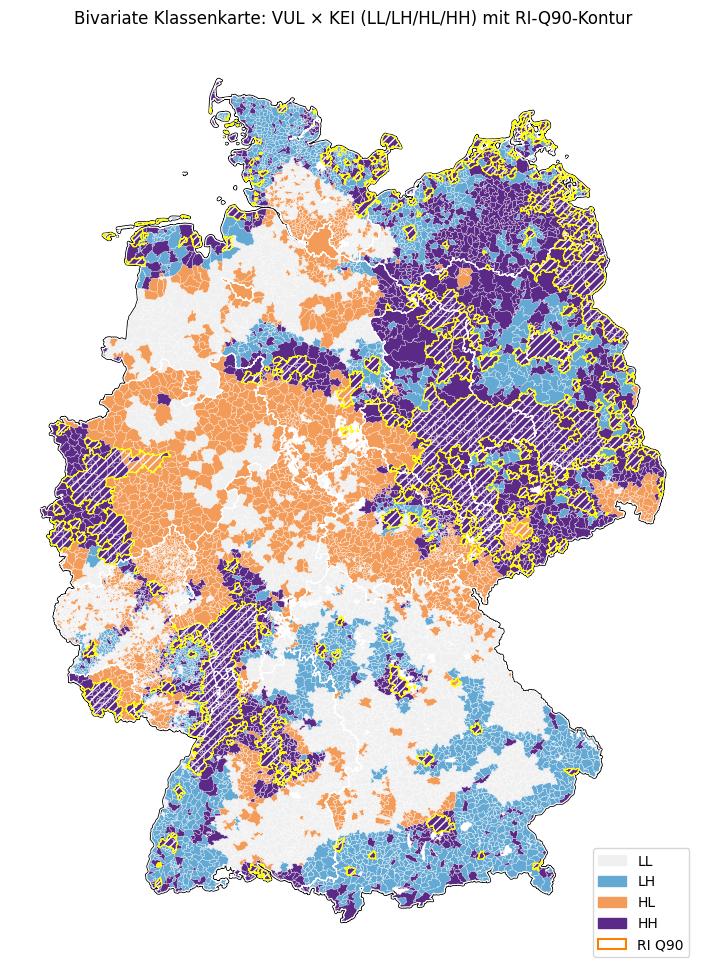

In [71]:
import matplotlib.patches as mpatches
# Annahme: gdf hat 'geometry', 'VUL_0_100', 'KEI_0_100', 'RI_0_100'
df = gdf2.copy()

# --- Schwellen wählen (Median; alternativ perzentil=0.60) ---
t_vul = df["VUL_0_100"].median()
t_kei = df["KEI_0_100"].median()
# t_vul = df["VUL_0_100"].quantile(0.60); t_kei = df["KEI_0_100"].quantile(0.60)  # optional

# --- 2×2-Klassen bilden ---
df["VUL_hi"] = df["VUL_0_100"] >= t_vul
df["KEI_hi"] = df["KEI_0_100"] >= t_kei
mapping = {
    (False, False): "LL",   # VUL niedrig, KEI niedrig
    (False, True) : "LH",   # klima-getrieben
    (True,  False): "HL",   # vulnerabilitäts-getrieben
    (True,  True) : "HH",   # Doppelbelastung
}
df["VK_class"] = [mapping[(v, k)] for v, k in zip(df["VUL_hi"], df["KEI_hi"])]
df["VK_class"] = pd.Categorical(df["VK_class"], categories=["LL","LH","HL","HH"], ordered=True)

# class_colors = {"LL":"#f4f1ec", "LH":"#D8D0C5", "HL":"#B3A79A", "HH":"#6E6257"}
class_colors = {"LL":"#F0F0F0", "LH":"#64A9D3", "HL":"#F39C5A", "HH":"#5B2A86"}
# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 10))

# Flächen je Klasse zeichnen 
for cls, color in class_colors.items():
    df[df["VK_class"] == cls].plot(ax=ax, color=color, edgecolor="none", linewidth=0)

# Dünne weiße Kreisgrenzen obenauf (optional)
df.boundary.plot(ax=ax, linewidth=0.2, color="white", alpha=0.6)

# Bundesland Umrisse
laender.boundary.plot(
    ax = ax,
    color= 'white',
    linewidth = 0.8,
)

staat.boundary.plot(
    ax= ax,
    color = 'black',
    linewidth = 2,
    zorder = 0,
)

# --- RI-Q90-Kontur berechnen und zeichnen ---
q90 = df["RI_0_100"].quantile(0.90)

df["RI_Q90"] = df["RI_0_100"] >= q90


if df["RI_Q90"].any():

    q90_union = df.loc[df["RI_Q90"], "geometry"].union_all()
    
    q90_gdf = gpd.GeoSeries([q90_union], crs=df.crs)
        
    q90_gdf.plot(
        ax=ax,
        facecolor = 'none',
        edgecolor = "#ffffff",
        linewidth = 0.5,
        hatch = '////',
    )
    
    q90_gdf.boundary.plot(
        ax=ax,
        color='yellow',
        linewidth=0.8
    )

ax.set_axis_off()
ax.set_title(
    "Bivariate Klassenkarte: VUL × KEI (LL/LH/HL/HH) mit RI-Q90-Kontur",
    pad=10
)

# Legende 
handles = [mpatches.Patch(color=class_colors[c], label=c) for c in ["LL","LH","HL","HH"]]
handles.append(mpatches.Patch(
    facecolor="none",
    edgecolor="#ff7f00",
    linewidth=1.5,
    label="RI Q90"))
ax.legend(handles=handles, loc="lower right", frameon=True)

plt.tight_layout()
plt.show()


In [72]:
# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"Bivariate_classes_RI_q90_kontur.png", 
    out_dir="exports",
    dpi=300
)

In [13]:
# speichern des Risikoindex
# gdf[['ARS','VUL','VUL_0_100','RI','RI_0_100','KEI','KEI_0_100']].to_csv('csv/RI.csv')

### Plotten

[  0.           3.57082199  11.86291211  30.37823555 100.        ]


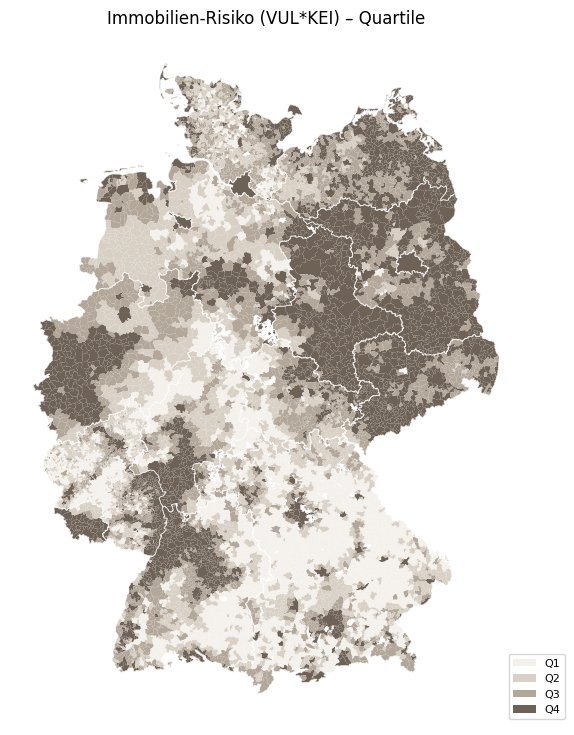

In [21]:
col = "RI_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

print(bins)
labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

# warm gray
colors = ['#F4F1EC', '#D8D0C5', '#B3A79A', '#6E6257']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="Immobilien-Risiko (VUL*KEI) – Quartile",
    # legend_offset_cm=1.0
)


In [10]:
# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"Risk_Qs.png", 
    out_dir="exports",
    dpi=300
)

### Hot spots

In [51]:
col = "RI_0_100"  

# 90% Quantil-Schwelle berechnen
q90 = gdf[col].quantile(0.9)
gdf_hot = gdf[gdf[col] > q90].copy().dissolve()

<Axes: title={'center': 'Immobilien-Risiko (VUL*KEI) – Quartile - Q90 Kontur'}>

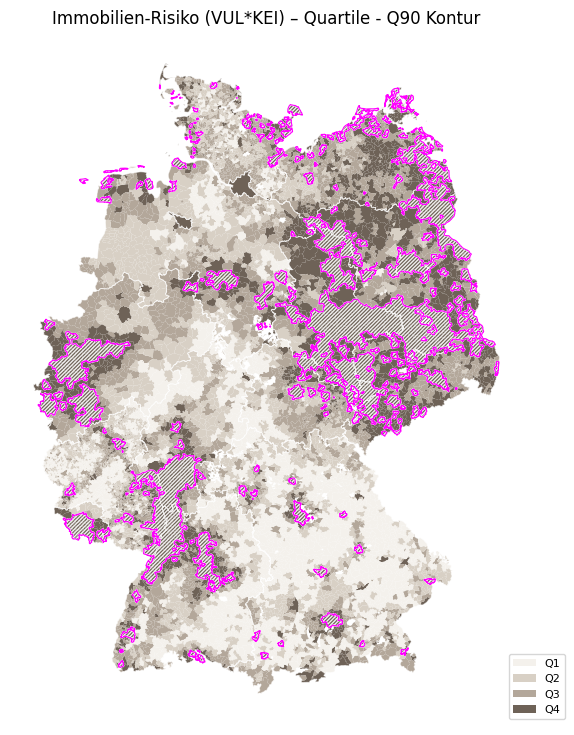

In [60]:
col = "RI_0_100"  

# Quartilschwellen (0, 25, 50, 75, 100 %)
qs = gdf[col].astype(float).quantile([0, .25, .5, .75, 1.0]).to_numpy()

# Falls Ties die Kanten zusammenfallen lassen → auf 4 Kanten strecken
bins = np.unique(qs)
if bins.size < 5:
    mn = float(np.nanmin(gdf[col]))
    mx = float(np.nanmax(gdf[col]))
    eps = np.nextafter(mx, np.inf) - mx
    bins = np.linspace(mn, mx + eps, 5)

# letzte Kante minimal anheben, damit das Maximum sicher inkludiert ist
bins[-1] = np.nextafter(bins[-1], np.inf)

labels = ["Q1", "Q2", "Q3", "Q4"][:bins.size - 1]

# warm gray
colors = ['#F4F1EC', '#D8D0C5', '#B3A79A', '#6E6257']

fig, ax = cp.plot_choropleth_discrete(
    gdf, col,
    bins=bins, labels=labels, colors=colors,
    laender=laender,
    title="Immobilien-Risiko (VUL*KEI) – Quartile - Q90 Kontur",
    # legend_offset_cm=1.0
)
gdf_hot.boundary.plot(
    ax = ax,
    # facecolor = 'white',
    color = 'white',
    hatch = '/////////',
    linewidth = 1.2,
    alpha = 0.9,
)
gdf_hot.boundary.plot(
    ax = ax,
    color = 'magenta',
    linewidth = 0.8,
)

In [56]:
# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"RI_scaled_quartiles_boundaryq90.png", 
    out_dir="exports",
    dpi=300
)